In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from HPA_CC.data.dataset import RefCLSDM, load_labels
from HPA_CC.models.train import find_checkpoint_file, PseudoRegressorLit
from HPA_CC.models.models import PseudoRegressor
from HPA_CC.utils.pseudotime import stretch_time
classes = ["M-G1", "G1", "S-G2", "G2"]

In [2]:
log_dirs_home = Path("/data/ishang/pseudotime_pred/")

In [3]:
split = (0.64, 0.16, 0.2)
data_dir = Path("/data/ishang/FUCCI-dataset-well")
data_name = "minimal"
device = "cuda:0"

In [4]:
model_name = "HPA DINO Angle Regressor"
model_hash = "u0livnza"
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = True # were intensity statistics added to the embedding? (not used from conv)
label_type = "angle" # "phase", "angle", or "pseudotime"
scope = None
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
angular_model = PseudoRegressorLit.load_from_checkpoint(checkpoint_file)
angular_model.to(device)
angular_model.eval()
angular_dataset = RefCLSDM(data_dir, data_name, 32, 1, split, (repr_type == "hpa_dino"), label_type, scope, int_stats)

Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/FUCCI-dataset-well/intensity_distributions_minimal.pt
X shape: torch.Size([31732, 1536])
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_angles.pt
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
X shape: torch.Size([31732, 2048])
Y shape: torch.Size([31732])


In [5]:
model_name = "HPA DINO Pseudotime Regressor"
model_hash = "81peszw2"
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = False # were intensity statistics added to the embedding? (not used from conv)
label_type = "pseudotime" # "phase", "angle", or "pseudotime"
scope = None
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
pseudo_model = PseudoRegressorLit.load_from_checkpoint(checkpoint_file)
pseudo_model.to(device)
pseudo_model.eval()
pseudo_dataset = RefCLSDM(data_dir, data_name, 32, 1, split, (repr_type == "hpa_dino"), label_type, scope, int_stats)

Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_pseudotime.pt
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
X shape: torch.Size([31732, 1536])
Y shape: torch.Size([31732])


In [6]:
phase_labels = load_labels("phase", data_dir, data_name, scope=(False if scope is None else True))
pseudo_labels = load_labels("pseudotime", data_dir, data_name)

Loading /data/ishang/FUCCI-dataset-well/minimal_sample_phase.pt
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_pseudotime.pt


In [7]:
def model_inference(model, dataloader):
    preds_list = []
    with torch.no_grad():
        for batch in iter(dataloader):
            x, y = batch
            x = x.to(device)
            pred = model(x)
            preds_list.append(pred.cpu())
    preds_test = torch.cat(preds_list, dim=0)
    std_preds_test = PseudoRegressor.angle_to_pseudo(preds_test).numpy()
    return std_preds_test
test_angular_preds = model_inference(angular_model, angular_dataset.test_dataloader()).squeeze()
test_pseudo_preds = model_inference(pseudo_model, pseudo_dataset.test_dataloader()).squeeze()

/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:135: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


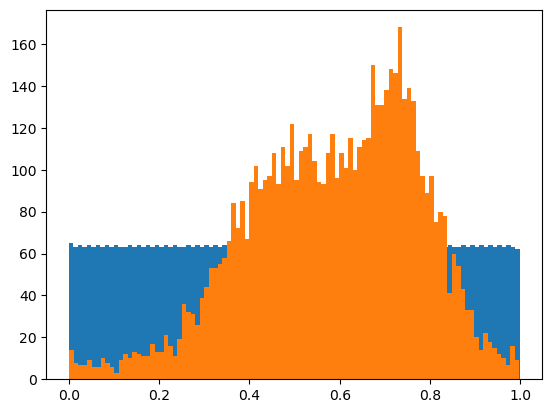

<Figure size 640x480 with 0 Axes>

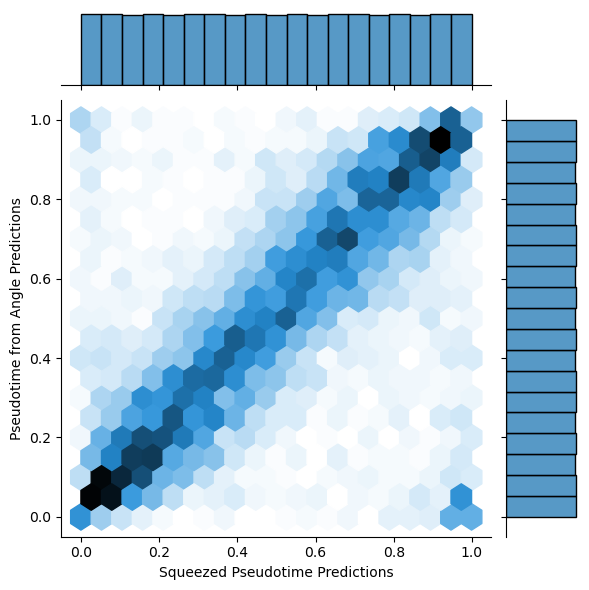

<Figure size 640x480 with 0 Axes>

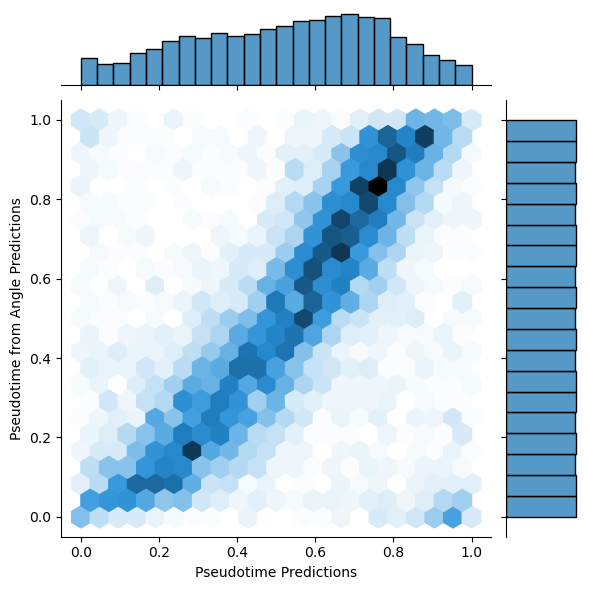

<Figure size 640x480 with 0 Axes>

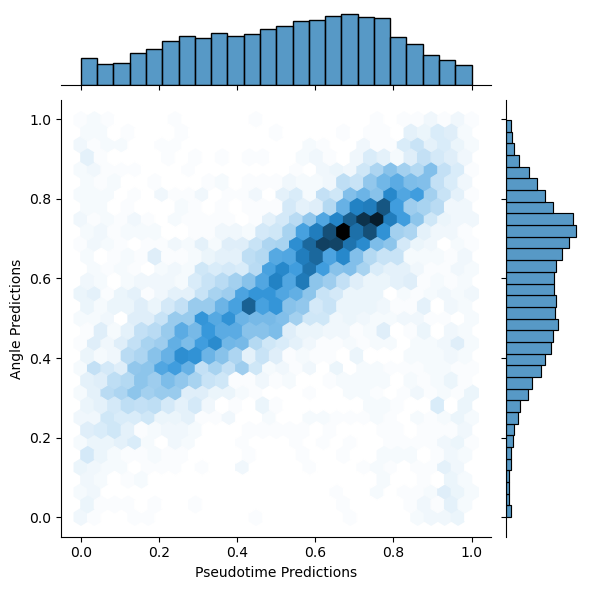

In [15]:
test_pseudo_from_ang = stretch_time(test_angular_preds)
squeezed_test_pseudo_preds = stretch_time(test_pseudo_preds)
plt.clf()
plt.hist(test_pseudo_from_ang, bins=100)
plt.hist(test_angular_preds, bins=100)
plt.show()
plt.clf()
df = pd.DataFrame({"Squeezed Pseudotime Predictions": squeezed_test_pseudo_preds, "Pseudotime from Angle Predictions": test_pseudo_from_ang})
sns.jointplot(data=df, x="Squeezed Pseudotime Predictions", y="Pseudotime from Angle Predictions", kind="hex")
plt.show()
plt.clf()
df = pd.DataFrame({"Pseudotime Predictions": test_pseudo_preds, "Pseudotime from Angle Predictions": test_pseudo_from_ang})
sns.jointplot(data=df, x="Pseudotime Predictions", y="Pseudotime from Angle Predictions", kind="hex")
plt.show()
plt.clf()
df = pd.DataFrame({"Pseudotime Predictions": test_pseudo_preds, "Angle Predictions": test_angular_preds})
sns.jointplot(data=df, x="Pseudotime Predictions", y="Angle Predictions", kind="hex")
plt.show()

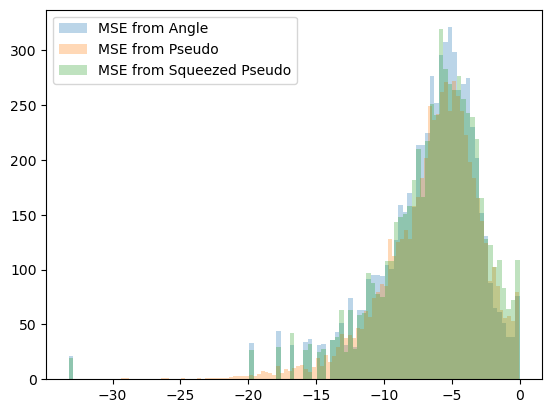

In [14]:
test_pseudo_labels = pseudo_labels[pseudo_dataset.split_indices["test"]]
mse_from_squeezed_angle = np.log2((test_pseudo_from_ang - test_pseudo_labels.numpy())**2 + 1e-10)
mse_from_pseudo = np.log2((test_pseudo_preds - test_pseudo_labels.numpy())**2 + 1e-10)
mse_from_squeezed_pseudo = np.log2((squeezed_test_pseudo_preds - test_pseudo_labels.numpy())**2 + 1e-10)
plt.clf()
plt.hist(mse_from_squeezed_angle, bins=100, alpha=0.3, label="MSE from Angle")
plt.hist(mse_from_pseudo, bins=100, alpha=0.3, label="MSE from Pseudo")
plt.hist(mse_from_squeezed_pseudo, bins=100, alpha=0.3, label="MSE from Squeezed Pseudo")
plt.legend()
plt.show()